In [204]:
import numpy as np
from numpy.fft import fft2, ifft2, fftshift
import matplotlib
from matplotlib import pyplot as plt
import scipy
from scipy.optimize import least_squares
from scipy.ndimage import gaussian_filter as gf
from scipy.signal import find_peaks
import tiff_file

In [21]:
%matplotlib notebook

In [34]:
#
#

#Set dimensions
nx = 128
ny = 128

drop_center = np.array([15,5])
drop_radius = 28

xx = np.arange(-(nx-1)/2. + drop_center[0], nx/2. + drop_center[0])
yy = np.arange(-(ny-1)/2. + drop_center[1], ny/2. + drop_center[1])
x,y = np.meshgrid(yy,xx)
q = drop_radius**2 - (x**2 + y**2)
angles = np.arctan2(x,y)

drop = q * (q>0)

<IPython.core.display.Javascript object>


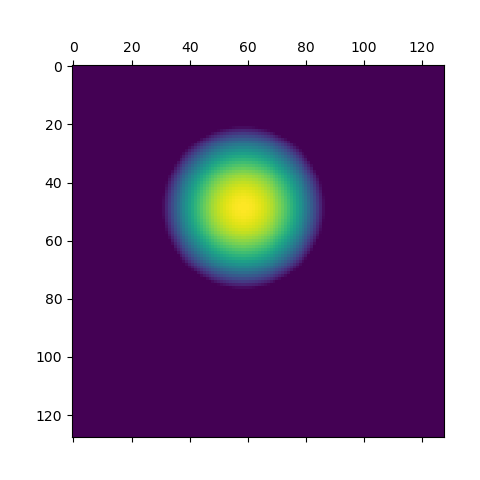

In [35]:
plt.matshow(drop)

In [41]:
deriv_x = drop[1:,:]-drop[:-1,:]
deriv_y = drop[:,1:]-drop[:,:-1]

deriv = deriv_x[:,1:] - deriv_y[1:,:]

<IPython.core.display.Javascript object>


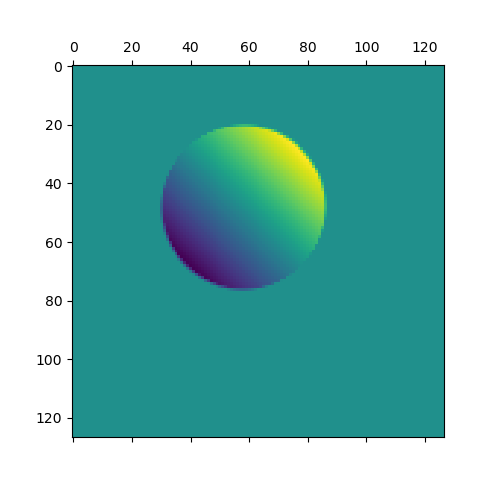

In [42]:
plt.matshow(deriv)

In [38]:
deriv.min()

-76.0

In [240]:
def droplet_dic_image(nx,ny,drop_radius,drop_center=np.array([0,0]), no_dic=False):

    xx = np.arange(-(nx-1)/2. + drop_center[0], nx/2. + drop_center[0])
    yy = np.arange(-(ny-1)/2. + drop_center[1], ny/2. + drop_center[1])
    x,y = np.meshgrid(yy,xx)
    q = drop_radius**2 - (x**2 + y**2)
    angles = np.arctan2(x,y)

    drop = q * (q>0)
    
    deriv_x = drop[1:,:]-drop[:-1,:]
    deriv_y = drop[:,1:]-drop[:,:-1]

    deriv = deriv_x[:,1:] - deriv_y[1:,:]
    
    deriv_new = np.zeros_like(drop)
    deriv_new[1:,1:] = deriv
    
    if no_dic:
        deriv_new = drop
        
    deriv_new = deriv_new - deriv_new.min()
    deriv_new = deriv_new / deriv_new.max()
    
    return deriv_new

<IPython.core.display.Javascript object>


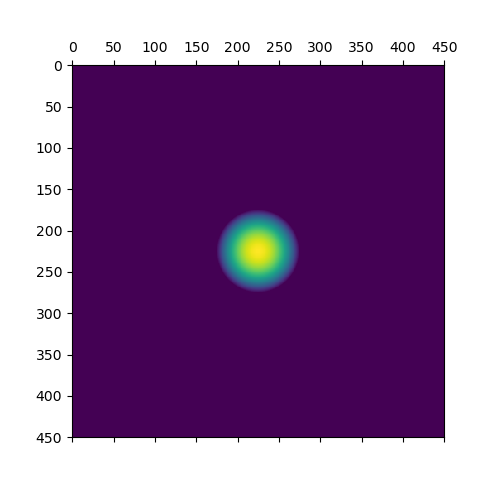

In [241]:
test_im = droplet_dic_image(450,450,50, no_dic=True)
plt.matshow(test_im)

In [51]:
test_im.min()

-138.0

In [277]:
data_dir = "D:\\Data\\Jack\\Data\\Capsule_Formation\\2020-02-28_XS_XLS_PFS\\"
data_file = "JB01_40X30S_60X_02.tif"

im = tiff_file.imread(data_dir+data_file)

In [112]:
def droplet_dic_image_error(params, true_image, nx, ny):
    
    drop_radius = params[0]
    drop_center_x = params[1]
    drop_center_y = params[2]

    #nx,ny = true_image.shape #get dimensions of the image
    true_image = true_image.reshape(nx,ny)
    
    drop_center = np.array([drop_center_x,drop_center_y])
    
    xx = np.arange(-(nx-1)/2. + drop_center[0], nx/2. + drop_center[0])
    yy = np.arange(-(ny-1)/2. + drop_center[1], ny/2. + drop_center[1])
    x,y = np.meshgrid(yy,xx)
    q = drop_radius**2 - (x**2 + y**2)
    angles = np.arctan2(x,y)

    drop = q * (q>0)
    
    deriv_x = drop[1:,:]-drop[:-1,:]
    deriv_y = drop[:,1:]-drop[:,:-1]

    deriv = deriv_x[:,1:] - deriv_y[1:,:]
    
    deriv_new = np.zeros_like(drop)
    deriv_new[1:,1:] = deriv
    
    deriv_new = deriv_new - deriv_new.min()
    deriv_new = deriv_new / deriv_new.max()
    
    true_image = (1.0*true_image) - true_image.min()
    true_image = true_image / true_image.max()
    
    error = true_image - deriv_new
    
    return error.ravel()

In [113]:
err = droplet_dic_image_error([140, -10, 0], im[100].ravel(), 450, 450)

<IPython.core.display.Javascript object>


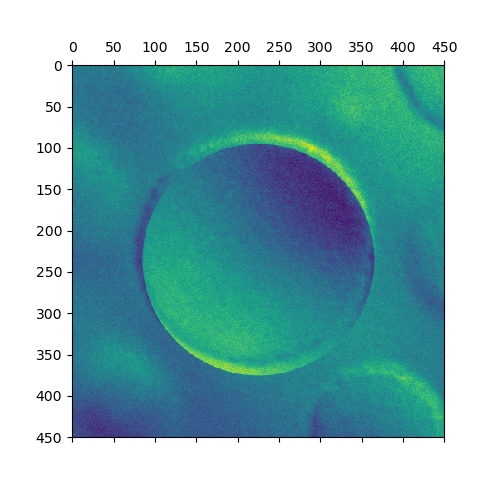

In [132]:
plt.matshow(err.reshape(450,450))


In [133]:
x0 = np.array([200,0,0]) #initial paramters: radius, x_center, y_center

res_lsq = least_squares(droplet_dic_image_error, x0, args=(gf(im[100],5).ravel(), 450, 450))

In [134]:
res_lsq

 active_mask: array([0., 0., 0.])
        cost: 3266.598891585309
         fun: array([-0.10894588, -0.10894588, -0.10894588, ...,  0.15667912,
        0.15667912,  0.15667912])
        grad: array([ 37.71413831,   6.95126917, -11.01578947])
         jac: array([[ 0.        , -0.00177936,  0.00177957],
       [ 0.        , -0.00177936,  0.00177957],
       [ 0.        , -0.00177936,  0.00177957],
       ...,
       [ 0.        , -0.00177936,  0.00177957],
       [ 0.        , -0.00177936,  0.00177957],
       [ 0.        , -0.00177936,  0.00177957]])
     message: 'Both `ftol` and `xtol` termination conditions are satisfied.'
        nfev: 32
        njev: 16
  optimality: 37.71413831152638
      status: 4
     success: True
           x: array([ 1.99575631e+02, -6.43516123e-02,  1.76815088e-01])

In [83]:
im[100].shape

(450L, 450L)

In [104]:
im_1d = im[100].ravel()

In [105]:
im_1d.shape

(202500L,)

<IPython.core.display.Javascript object>


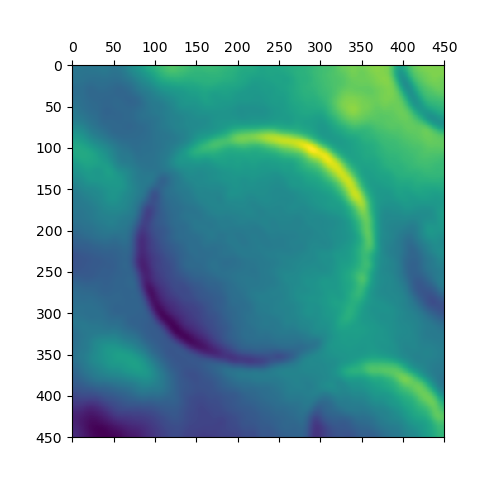

In [127]:
plt.matshow(gf(im[100], 5))

In [186]:
test_im = droplet_dic_image(450,450,148)

In [193]:
im_corr = fftshift(ifft2(fft2(test_im)*np.conj(fft2(im[0]*1.0))))
nx,ny = im[0].shape
xc = nx/2
yc = ny/2
im_corr_central_region = abs(im_corr[xc-(nx/4):xc+(nx/4), yc-(ny/4):yc+(ny/4)])

<IPython.core.display.Javascript object>


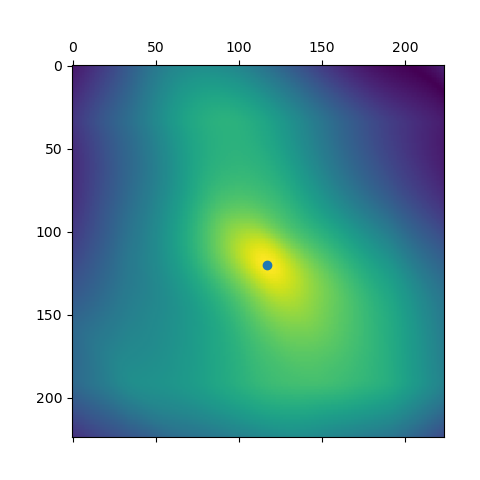

In [197]:
plt.matshow(im_corr_central_region)
arg_max =np.unravel_index(im_corr_central_region.argmax(), im_corr_central_region.shape)
plt.scatter(arg_max[1], arg_max[0])

In [269]:
def correlation(true_image, start_radius, stop_radius, stepsize, center, no_dic=False, peak_width=5):
    true_image = (1.0*true_image)-true_image.min()
    true_image = true_image / true_image.max()
    radii = np.arange(start_radius,stop_radius+1,stepsize)
    corr_peak_values = np.zeros_like(radii,dtype=np.int64)
    corr_peak_positions = np.zeros((len(radii),2))
    nx,ny = true_image.shape
    for i,r in enumerate(radii):
        test_im = droplet_dic_image(nx,ny,r,drop_center=center,no_dic=no_dic)
        im_corr = abs(fftshift(ifft2(fft2(test_im)*np.conj(fft2(true_image*1.0)))))
        xc = nx/2
        yc = ny/2
        im_corr_central_region = im_corr[xc-(nx/4):xc+(nx/4), yc-(ny/4):yc+(ny/4)]
        corr_peak_values[i] = im_corr_central_region.max()
        arg_max = np.unravel_index(im_corr_central_region.argmax(), im_corr_central_region.shape)
        corr_peak_positions[i] = arg_max
    pfit = scipy.polyfit(radii, corr_peak_values,1)
    linear_fit = scipy.polyval(pfit, radii)
    peak_a = find_peaks(corr_peak_values-linear_fit,width=peak_width)
    peak_radii = radii[peak_a[0]]
    peak_pos = corr_peak_positions[peak_a[0]]
    return radii,corr_peak_values-linear_fit, corr_peak_positions, peak_radii, peak_pos

In [290]:
plt.figure()
gf_size = 4
r_a,cpv_a, cpp_a, pra, pp = correlation(gf(im[480],gf_size), 80, 180, 2, [0,0],no_dic=True)
r_b,cpv_b, cpp_b, prb, pp = correlation(gf(im[503],gf_size), 100, 170, 2, [0,0],no_dic=True)
r_c,cpv_c, cpp_c, prc, pp = correlation(gf(im[510],gf_size), 80, 180, 2, [0,0],no_dic=True)
r_d,cpv_d, cpp_d, prd, pp = correlation(gf(im[515],gf_size), 100, 180, 2, [0,0],no_dic=True)
plt.plot(r_a,cpv_a,'ro')
plt.axvline(pra[0])
plt.plot(r_b,cpv_b,'bo')
plt.axvline(prb[0])
plt.plot(r_c,cpv_c,'go')
plt.plot(r_d,cpv_d,'mo')

<IPython.core.display.Javascript object>

IndexError: index 0 is out of bounds for axis 0 with size 0

<IPython.core.display.Javascript object>


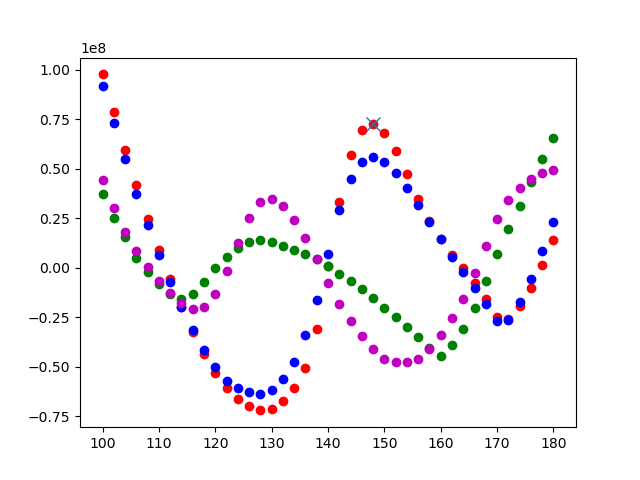

In [210]:
plt.figure()
plt.plot(r_a,cpv_a,'ro')
peak_a = find_peaks(cpv_a)
plt.plot(r_a[peak_a[0]],cpv_a[peak_a[0]],'x',ms=10)
plt.plot(r_b,cpv_b,'bo')
plt.plot(r_c,cpv_c,'go')
plt.plot(r_d,cpv_d,'mo')

In [207]:
peak_a

(array([24], dtype=int64), {})

In [314]:
frames = np.arange(400, 600, 2)
found_radius = np.zeros_like(frames)
found_position = np.zeros((len(frames),2))
for i,fr in enumerate(frames):
    if fr>499:
        no_dic=True
    else:
        no_dic=False
    r_a,cpv_a, cpp_a, pr, pp = correlation(gf(im[fr],2), 100, 170, 2, [0,0],no_dic=no_dic)
    print fr,pr
    if len(pr)>0:
        found_radius[i] = pr[0]
        found_position[i] = pp[0]

400 [152]
402 [152]
404 [152]
406 [152]
408 [152]
410 [152]
412 [152]
414 [152]
416 [152]
418 [152]
420 [152]
422 [152]
424 [152]
426 [152]
428 [152]
430 [152]
432 [152]
434 [152]
436 [152]
438 [150]
440 [150]
442 [148]
444 [148]
446 [148]
448 [148]
450 [148]
452 [148]
454 [148]
456 [148]
458 [148]
460 [148]
462 [148]
464 [148]
466 [148]
468 [148]
470 [148]
472 [148]
474 [148]
476 [148]
478 [148]
480 [146]
482 [146]
484 [146]
486 [144]
488 [144]
490 [144]
492 [142]
494 [142]
496 [142]
498 [140]
500 []
502 [148]
504 [144]
506 [142]
508 [138]
510 [138]
512 [136]
514 [136]
516 [134]
518 [134]
520 [134]
522 [134]
524 [134]
526 [134]
528 [134]
530 [134]
532 [134]
534 [134]
536 [134]
538 [136]
540 [134]
542 [134]
544 [134]
546 [134]
548 [134]
550 [134]
552 [134]
554 [136]
556 [134]
558 [136]
560 [136]
562 [136]
564 [134]
566 [134]
568 [134]
570 [134]
572 [134]
574 [134]
576 [134]
578 [132]
580 [134]
582 [134]
584 [132]
586 [132]
588 [132]
590 [132]
592 [132]
594 [132]
596 [132]
598 [132]


<IPython.core.display.Javascript object>


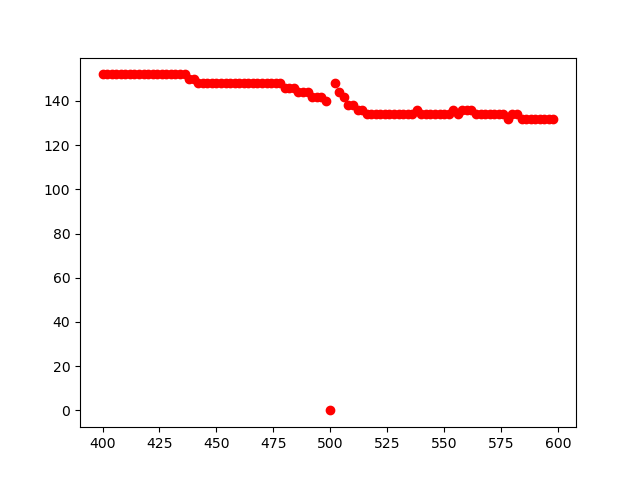

<IPython.core.display.Javascript object>


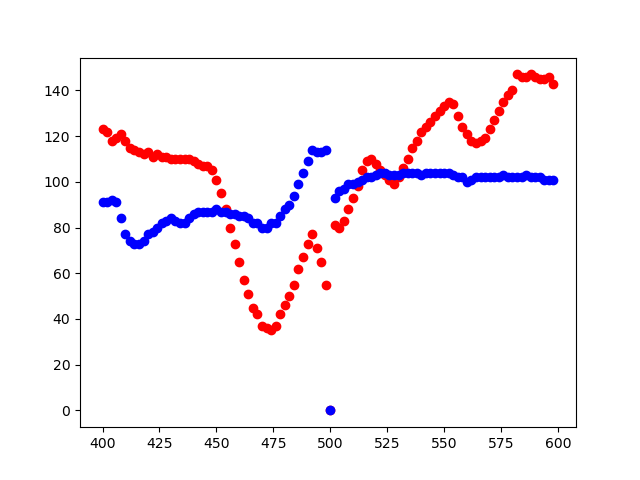

In [317]:
plt.figure()
plt.plot(frames, found_radius, 'ro')
plt.figure()
plt.plot(frames, found_position[:,0], 'ro')
plt.plot(frames, found_position[:,1], 'bo')

<IPython.core.display.Javascript object>


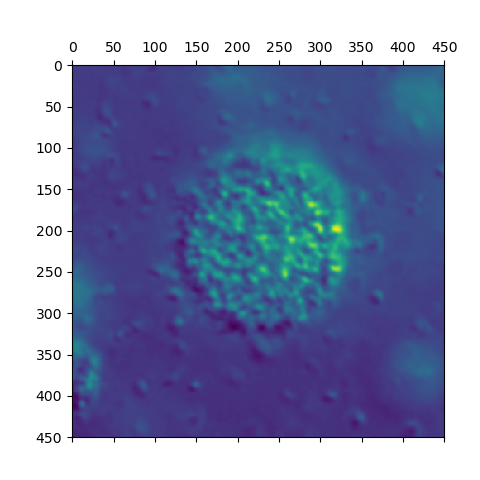

In [313]:
plt.matshow(gf(im[1370],2))